# Chest X-Ray Images Classification (Pneumonia)

The dataset used for the project is taken from the [Chest X-Ray Image (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) kaggle competition.

It consists of **5863 X-Ray images** (JPEG format) and 2 categories (**Pneumonia/Normal**), divided into:
- **train**: 1341 Normal, 3875 Pneumonia
- **test**: 234 Normal, 390 Pneumonia

The task that will be performed on this datasets consists in training a **binary classifier** which correctly identifies X-Ray images of lungs affected by peneumonia. To do this I am goig to use different strategies that will be explained along the notebook.

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from easydict import EasyDict as edict

In [2]:
# the following edict will contain all the paths and hyperparameters
# needed for the training of the NN
config = edict()
config.model_path = "./models/model.h5"
config.best_model_path = "./best_model.h5"
config.scnnb_path = "./models/scnnb.h5"
config.transfer_learning_model_path = "./models/tl_model.h5"
config.datapath = "./chest_xray/"
config.history_path = "./models/history.json"

config.img_size = (224, 224, 3)
config.lr = 1e-3
config.lr_decay = 0.03
config.threshold = 0.9

config.TRAIN = edict()
config.TRAIN.dir_path = "./chest_xray/train/"
config.TRAIN.batch_size = 32

config.TEST = edict()
config.TEST.dir_path = "./chest_xray/test/"

Let's take a look at a couple of images

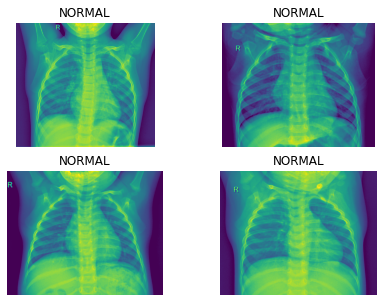

In [4]:
# images of Normal chest
normal_path = os.path.join(config.TRAIN.dir_path, "NORMAL")
filenames = os.listdir(normal_path)

plt.figure(figsize=(7, 5))
for i, fname in enumerate(filenames[:4]):
    plt.subplot(2, 2, i+1)
    img = plt.imread(os.path.join(normal_path, fname))
    plt.title("NORMAL")
    plt.imshow(img)
    plt.axis('off')

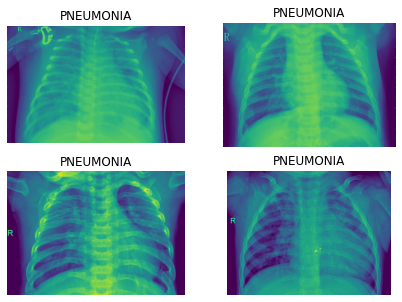

In [5]:
# images of Peneumonia affected chest
pneu_path = os.path.join(config.TRAIN.dir_path, "PNEUMONIA")
filenames = os.listdir(pneu_path)

plt.figure(figsize=(7, 5))

for i, fname in enumerate(filenames[:4]):
    plt.subplot(2, 2, i+1)
    img = plt.imread(os.path.join(pneu_path, fname))
    plt.title("PNEUMONIA")
    plt.imshow(img)
    plt.axis('off')

Once we have tested the visualization of the images in the dataset, we can load the whole dataset using keras.

### Data loading and preprocessing

We can create our data generators for training, validation and test set. To each dataset is applied preprocessing, while augmentation is applied just to train and validation dataset.

In [3]:
def augment(img):
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.1, 0.2)
    return img

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   preprocessing_function=augment,
                                   validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [5]:
train_gen = train_datagen.flow_from_directory(config.TRAIN.dir_path,
                                             seed=0,
                                             batch_size=config.TRAIN.batch_size,
                                             target_size=config.img_size[:2],
                                             class_mode='binary',
                                             shuffle=True,
                                             subset='training')

val_gen = train_datagen.flow_from_directory(config.TRAIN.dir_path,
                                            seed=0,
                                            batch_size=config.TRAIN.batch_size,
                                            target_size=config.img_size[:2],
                                            class_mode='binary',
                                            shuffle=True,
                                            subset='validation')

test_gen = test_datagen.flow_from_directory(config.TEST.dir_path,
                                            seed=0,
                                            batch_size=1,
                                            target_size=config.img_size[:2],
                                            class_mode='binary',
                                            shuffle=False)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model training

As already specified above, the goal that we want to accomplish is to train a NN classifier which correctly identifies X-Ray images of lungs affected by peneumonia.

To build the NN, I'm going to try 3 different approaches:
1. Building the a custom CNN;
2. Building a SCNNB (description and reference to the paper are in the SCNNB training section)
3. Using a pre-trained model and applying transfer learning on the X-Ray dataset.

Then I'm going to choose the best one between on the basis of various metrics (accuracy, auc, roc curve, FPR, FNR) and use it in the last section of the notebook (interpreting the model).

### Building the custom CNN

The custom CNN will be composed of multiple blocks, each one made up of a **Conv2D** layer, a **MaxPooling2D** layer and a **BatchNormalization** layer.

The Conv2D layers will use a **relu** activation function and **3x3 filters**, while the MaxPooling2D ones will have a 2x2 filter.

Eventually, **Dropout** will be tested and if it improves the results it will be kept in the CNN.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, InputLayer, Conv2D, MaxPooling2D, 
                                     BatchNormalization, GlobalAveragePooling2D, 
                                     Flatten, Dense, Dropout, ReLU)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

In [7]:
def add_conv_block(x, filters, max_pool=False):
    x = Conv2D(filters, (3,3))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    if max_pool:
        x = MaxPooling2D((2,2), 2)(x)
    return x


def add_n_blocks(x, n_blocks=3, start_filters=32):
    for i in range(n_blocks):
        x = add_conv_block(x, filters=start_filters*(2**i))
        x = add_conv_block(x, filters=start_filters*(2**i), max_pool=True)
    return x


def get_model():
    
    inp = Input(shape=config.img_size)
    
    x = add_n_blocks(inp)
        
    # flattening
    x = Flatten()(x)
    # hidden dense layer
    x = Dense(200, activation='relu')(x)  # 128
    x = Dropout(0.3)(x)  # 0.3
        
    # output layer for binary prediction
    x = Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inp, x)

For the training of the model we will use the ```binary_crossentropy``` as loss function, ```Adam``` as optimizer and ```BinaryAccuracy``` as metric score.

In [8]:
def compile_model(model, lr=config.lr):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr, decay=config.lr_decay),
                  metrics=BinaryAccuracy(threshold=config.threshold))
    return model

In [83]:
model = get_model()

In [84]:
model = compile_model(model)

In [85]:
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
re_lu_30 (ReLU)              (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
re_lu_31 (ReLU)              (None, 220, 220, 32)    

One thing to consider before starting the training is the fact that the proportion of images for the 2 classes is imbalanced. So, we can set specific weights for the loss function which will help balance the final output of the model.

In [86]:
train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [9]:
n_normal = sum(train_gen.classes == 0)
n_pneu = sum(train_gen.classes == 1)
tot = train_gen.samples

weights = {0: (n_normal/tot),
           1: (n_pneu/tot)}
weights

{0: 0.25708200212992544, 1: 0.7429179978700745}

In [88]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                         patience=7, restore_best_weights=False)
model_cp = callbacks.ModelCheckpoint(config.best_model_path, monitor='val_binary_accuracy', 
                                     verbose=1, save_best_only=True, mode='auto')

callbacks = [early_stopping, model_cp]

In [89]:
history = model.fit(train_gen, epochs=20,
                    validation_data=val_gen,
                    class_weight=weights,
                    callbacks=callbacks)

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 1.7877 - binary_accuracy: 0.6692
Epoch 00001: val_binary_accuracy improved from -inf to 0.74280, saving model to .\best_model.h5
147/147 [==============================] - 119s 811ms/step - loss: 1.7877 - binary_accuracy: 0.6692 - val_loss: 0.8011 - val_binary_accuracy: 0.7428
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 0.4425 - binary_accuracy: 0.7414
Epoch 00002: val_binary_accuracy did not improve from 0.74280
147/147 [==============================] - 117s 793ms/step - loss: 0.4425 - binary_accuracy: 0.7414 - val_loss: 1.0326 - val_binary_accuracy: 0.7428
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 0.2492 - binary_accuracy: 0.8200
Epoch 00003: val_binary_accuracy did not improve from 0.74280
147/147 [==============================] - 119s 812ms/step - loss: 0.2492 - binary_accuracy: 0.8200 - val_loss: 0.5706 - val_binary_accuracy: 0.7351
Epoch 4/20
147/147 [====

In [90]:
model.evaluate(test_gen)

624/624 [==============================] - 8s 14ms/step - loss: 7.6014 - binary_accuracy: 0.8045


[7.601358413696289, 0.8044871687889099]

In [92]:
best_model = tf.keras.models.load_model(config.best_model_path)
best_model.evaluate(test_gen)

624/624 [==============================] - ETA: 0s - loss: 1.3620 - binary_accuracy: 0.858 - 9s 14ms/step - loss: 1.3599 - binary_accuracy: 0.8590


[1.3598514795303345, 0.8589743375778198]

#### Loss and Binary Accuracy history

In [91]:
import json

with open('history.json', 'w') as f:
    json.dump(history.history, f)

In [93]:
val_loss, val_acc = best_model.evaluate(val_gen)
test_loss, test_acc = best_model.evaluate(test_gen)

624/624 [==============================] - 8s 13ms/step - loss: 1.3599 - binary_accuracy: 0.8590: 15s - loss: 1.1451 - binary_ac - ETA: 17s - loss: 1.1543 - b


In [94]:
print("Loss on validation dataset: {}".format(round(val_loss, 4)))
print("Accuracy on validation dataset: {}".format(round(val_acc, 4)))
print()
print("Loss on test dataset: {}".format(round(test_loss, 4)))
print("Accuracy on test dataset: {}".format(round(test_acc, 4)))

Loss on validation dataset: 0.2148
Accuracy on validation dataset: 0.9367

Loss on test dataset: 1.3599
Accuracy on test dataset: 0.859


As we can see, the model slightly overfitted the training data but, however, performed good when predicting using the test dataset.

Let's now take a look at the training history.

In [95]:
def plot_history(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val_Loss')
    plt.legend()
    plt.show()

    plt.title('Accuracy')
    plt.plot(history.history['binary_accuracy'], label='Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Val_Accuracy')
    plt.legend()
    plt.show()

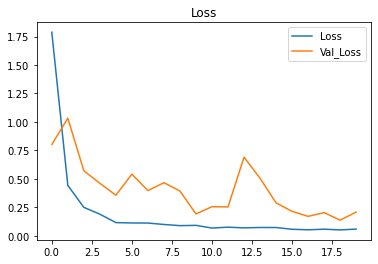

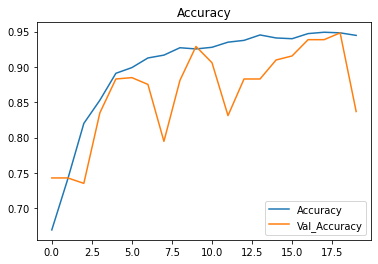

In [96]:
plot_history(history)

#### Prediction evaluation

What we are working on is a **Binary Classification**, so we need to evaluate the probabilities predicted by the model and understand if the threshold we used in training is actually good.

First of all let's take a look at the distribution of the predicted probabilities over the test set.

Let's also compute the **area under the curve (AUC)** and plot the **ROC curve**.

Finally, let's take a look at different evaluation metrics after performing the classification with the choosen threshold.

In [132]:
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, classification_report, confusion_matrix

def evaluate_predictions(model):
    preds_f = model.predict(test_gen)
    preds_f = preds_f.reshape(1, -1)[0]
    g = sns.displot(preds_f, kde=True)
    g.set_xlabels("Probabilities distribution")
    plt.show()
    
    true_y = test_gen.classes
    fpr, tpr, thresholds = roc_curve(true_y, preds_f)
    auc = roc_auc_score(true_y, preds_f)
    print('AUC: %.3f' % auc)
    
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    preds = (preds_f > config.threshold).astype(int)
    print(classification_report(true_y, preds, 
                            target_names= ['0: NORMAL', '1: PNEUMONIA']))
    cm = confusion_matrix(true_y, preds)
    cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])
    labels = ['NORMAL', 'PNEUMONIA']
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(cm, cmap= "Blues", linecolor = 'black', linewidth = 1,
               annot = True, fmt = '', xticklabels = labels, yticklabels = labels)

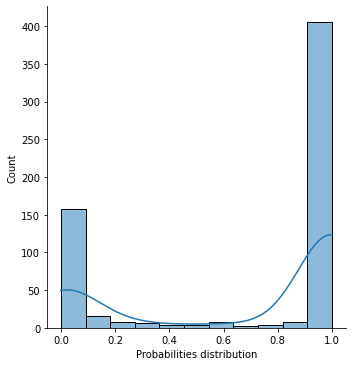

AUC: 0.897


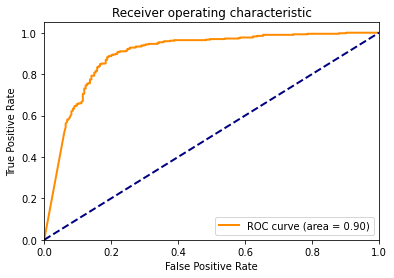

              precision    recall  f1-score   support

   0: NORMAL       0.83      0.78      0.81       234
1: PNEUMONIA       0.87      0.91      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624



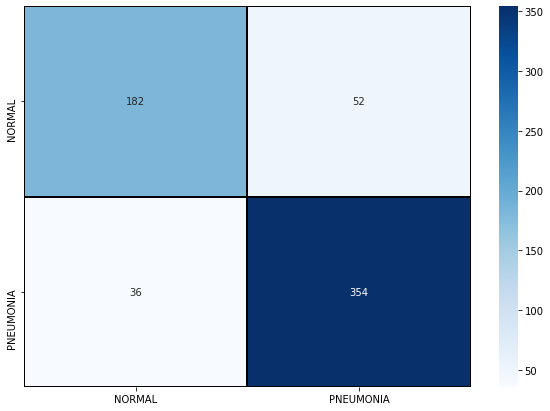

In [133]:
evaluate_predictions(best_model)

As we can see, the model is very good at recognizing PNEUMONIA cases, which is the most important thing, while it is sligthly less good at recognizing HEALTY cases. This could be due to the imbalanced dataset.

Moreover, even though the accuracy is "just" 0.86, precision, recall and f1-score tell us more about how the CNN is behaving. Specifically, for PNEUMONIA cases we have high values for those metrics, while we have slightly lower values for NORMAL cases. In our case this is not a bad thing because the model is sometimes predicting a NORMAL X-RAY as a PNEUMONIA affected one (FP), while the FN cases are less in comparison. 

In a medical environment this is a good situation because FP cases (type 1 errors) can be recoved in the future with new diagnosis, while it is usually difficult to recover a FN.

In [103]:
model.save(config.model_path)

### SCNNB

The results obtained with the Deep Neural Network trained before are good enough, but this doesn't meen that we cannot do better.

So, before moving to transfer learnig using a pre-trained NN, we can give a try to a **Shallow Convolutional Neural Network** proposed in the [paper by Fangyuan Lei et al.](https://link.springer.com/article/10.1007/s42452-019-1903-4). The **SCNNB** with batch normalization model is composed of 2 blocks, identical to the ones of the previous network, each one with a convolutional layer, a batch-normalization layer with ReLU and a max-pooling layer. The output is given by a fully-connected layer with dropout and by a final layer with sigmoid activation. For more informations I suggest to check out the papaer.

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs42452-019-1903-4/MediaObjects/42452_2019_1903_Fig1_HTML.png" alt="SCNNB" width="200"/>

In [10]:
def get_SCNNB():
    inp = Input(shape=config.img_size)
    
    x = add_conv_block(inp, 32, True)
    x = add_conv_block(x, 32, True)
    x = Flatten()(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.3)(x)
        
    # the softmax is substituted by a sigmoid given the goal of binary classification
    x = Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inp, x)

In [105]:
scnnb = get_SCNNB()

In [106]:
scnnb = compile_model(scnnb)

In [107]:
scnnb.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 109, 109, 32)    

The model has been trained for 20 epochs in total.

In [108]:
res = scnnb.fit(train_gen, epochs=10,
                validation_data=val_gen,
                class_weight=weights,
                callbacks=[early_stopping])

Epoch 1/10
147/147 [==============================] - 86s 587ms/step - loss: 1.2428 - binary_accuracy: 0.8060 - val_loss: 0.5933 - val_binary_accuracy: 0.4223
Epoch 2/10
147/147 [==============================] - 95s 645ms/step - loss: 0.0998 - binary_accuracy: 0.8822 - val_loss: 0.5009 - val_binary_accuracy: 0.6564
Epoch 3/10
147/147 [==============================] - 99s 676ms/step - loss: 0.0783 - binary_accuracy: 0.9033 - val_loss: 0.3477 - val_binary_accuracy: 0.8138
Epoch 4/10
147/147 [==============================] - 95s 649ms/step - loss: 0.0649 - binary_accuracy: 0.9165 - val_loss: 0.3308 - val_binary_accuracy: 0.8925
Epoch 5/10
147/147 [==============================] - 95s 650ms/step - loss: 0.0643 - binary_accuracy: 0.9244 - val_loss: 0.2619 - val_binary_accuracy: 0.9232
Epoch 6/10
147/147 [==============================] - 96s 655ms/step - loss: 0.0605 - binary_accuracy: 0.9244 - val_loss: 0.2221 - val_binary_accuracy: 0.9347
Epoch 7/10
147/147 [==========================

In [109]:
scnnb.evaluate(test_gen)

624/624 [==============================] - 11s 17ms/step - loss: 1.0221 - binary_accuracy: 0.8606


[1.0220710039138794, 0.8605769276618958]

In [136]:
scnnb.save(config.scnnb_path)

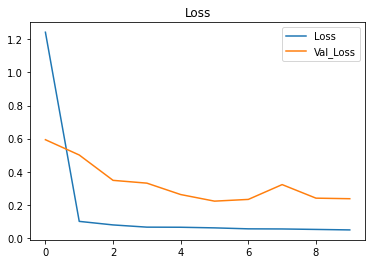

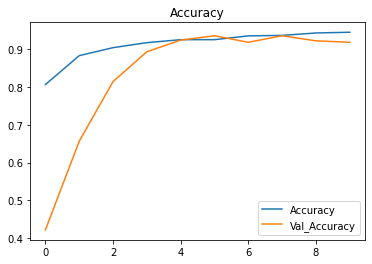

In [110]:
plot_history(res)

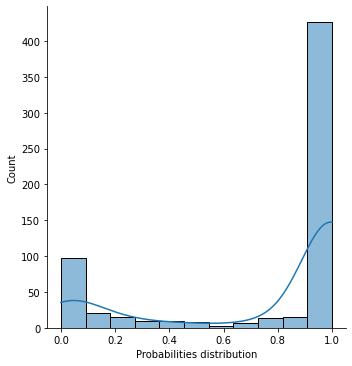

AUC: 0.933


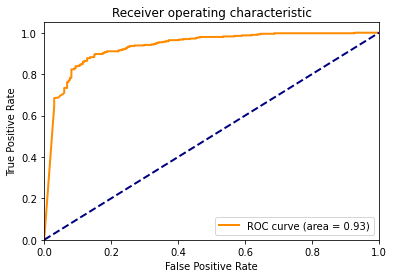

              precision    recall  f1-score   support

   0: NORMAL       0.87      0.74      0.80       234
1: PNEUMONIA       0.85      0.94      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624



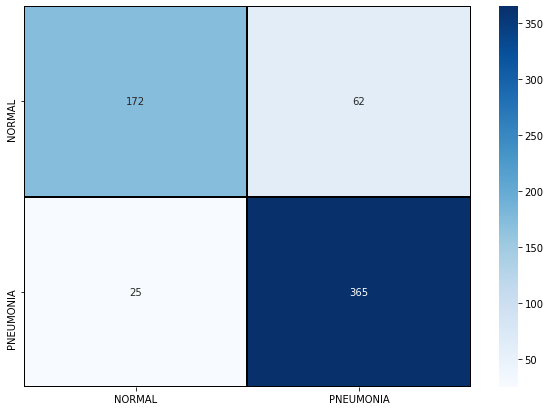

In [134]:
evaluate_predictions(scnnb)

The results with this new architecure are better in general than the ones obtained with the custom CNN. The network is better at recognizing PNEUMONIA cases (which is the main goal) and slightly worse with NORMAL cases.

### Transfer Learning on a ResNet50

The last step consists in trying to apply transfer learning on a ResNet50.

Note: multiple tests have been done with different hyper-parameters, but in neither of them the network seemed to be able to learn, at least in under 40 epochs.

In [137]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [153]:
def add_top_block(base_model):
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(20, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(base_model.input, x)
    return model

In [154]:
base_model = ResNet50(include_top=False, weights=None, input_shape=config.img_size)

for layer in base_model.layers:
    layer.trainable = False

In [155]:
resnet = add_top_block(base_model)

In [156]:
resnet = compile_model(resnet)
resnet.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [157]:
res = resnet.fit(train_gen, validation_data=val_gen, 
                 epochs=5, class_weight=weights,
                 callbacks=[early_stopping])

Epoch 1/5
147/147 [==============================] - 110s 749ms/step - loss: 0.2408 - binary_accuracy: 0.4577 - val_loss: 0.5990 - val_binary_accuracy: 0.2956
Epoch 2/5
147/147 [==============================] - 113s 771ms/step - loss: 0.2325 - binary_accuracy: 0.4437 - val_loss: 0.6193 - val_binary_accuracy: 0.3877
Epoch 3/5
147/147 [==============================] - 111s 758ms/step - loss: 0.2305 - binary_accuracy: 0.4535 - val_loss: 0.6422 - val_binary_accuracy: 0.5355
Epoch 4/5
147/147 [==============================] - 111s 753ms/step - loss: 0.2273 - binary_accuracy: 0.4673 - val_loss: 0.6079 - val_binary_accuracy: 0.3704
Epoch 5/5
147/147 [==============================] - 108s 738ms/step - loss: 0.2305 - binary_accuracy: 0.4435 - val_loss: 0.6104 - val_binary_accuracy: 0.3743


In [159]:
resnet.evaluate(test_gen)

624/624 [==============================] - 13s 20ms/step - loss: 0.8061 - binary_accuracy: 0.4455 3s -  - ETA: 1s - loss: 0.8747 - bin


[0.8060843348503113, 0.4455128312110901]

In [160]:
resnet.save(config.transfer_learning_model_path)

After multiple tests, the resnet doesn't seem to be able to learn from the dataset.

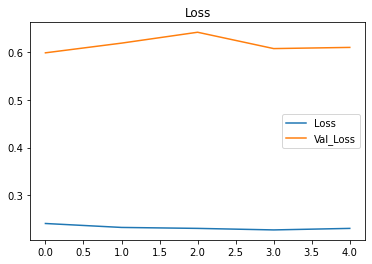

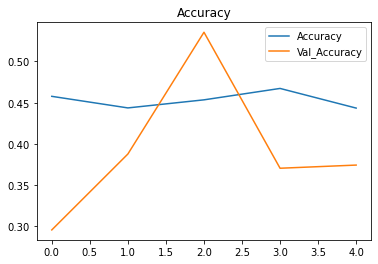

In [161]:
plot_history(res)

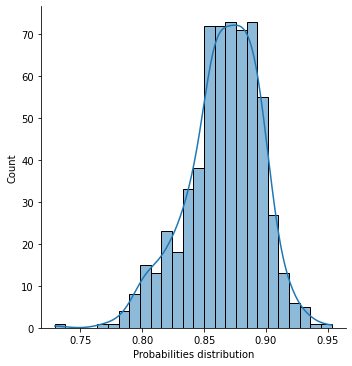

AUC: 0.740


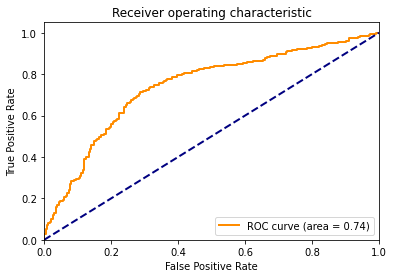

              precision    recall  f1-score   support

   0: NORMAL       0.40      0.97      0.57       234
1: PNEUMONIA       0.88      0.13      0.23       390

    accuracy                           0.45       624
   macro avg       0.64      0.55      0.40       624
weighted avg       0.70      0.45      0.36       624



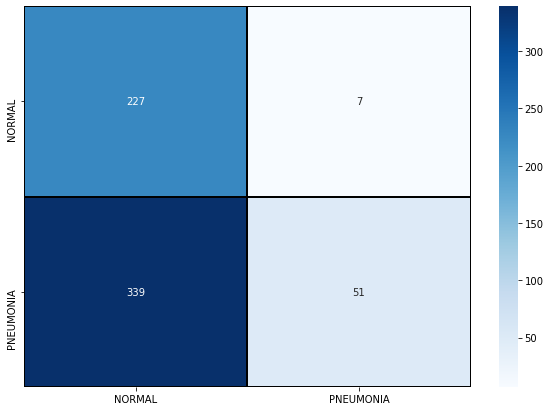

In [162]:
evaluate_predictions(resnet)

## Interpreting the model

The final step choosen for the completion of the project is the interpretation of the best model trained up to now. In this case the model is the one with the **SCNNB architecture**.

I'm going to use the **tf-explain** library to interpret the model and visualize how the layers are activated.

### tf-explain

Before starting with the interpretation of the model, I would like to highlight a "catch" I found.

All the models trained above are Binary Classificators, this means that their output will be the probability of appartaining to a class.

As also described in this [github issue](https://github.com/sicara/tf-explain/issues/73), most of the interpretability approaches show the pixel activated in the image just when the image classifies with the first class (class 0), while almost nothing is present in the output grid when the target class is the second one (rejection of class 0).

In our specific case, what happens is that when using GradCAM, activation maps light up just for images whose class is NORMAL, but do not show activations for images with class PNEUMONIA.

In [11]:
import random
from tf_explain.core import GradCAM, IntegratedGradients

#### On trained model

In [6]:
model = tf.keras.models.load_model(config.scnnb_path)

In [7]:
def get_img_path(normal=True):
    if normal:
        path = os.path.join(config.TEST.dir_path, "NORMAL/")
    else:
        path = os.path.join(config.TEST.dir_path, "PNEUMONIA/")
    imgs = os.listdir(path)
    random.Random(1).shuffle(imgs)
    img = imgs[0]
    return img

In [8]:
# select an image from the NORMAL cases
norm_img_name = get_img_path()
print(norm_img_name)

# select an image from the PNEUMONIA cases
pneu_img_name = get_img_path(False)
print(pneu_img_name)

NORMAL2-IM-0051-0001.jpeg
person109_bacteria_519.jpeg


In [9]:
def read_image(img_name, normal=True):
    if normal:
        path = os.path.join(config.TEST.dir_path, "NORMAL/")
    else:
        path = os.path.join(config.TEST.dir_path, "PNEUMONIA/")
        
    img_path = os.path.join(path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=config.img_size[:2])
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.
    return img

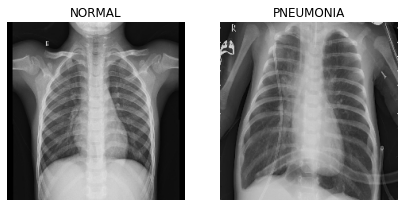

In [10]:
# read and rescale the image
norm_img = read_image(norm_img_name)
pneu_img = read_image(pneu_img_name, False)
images = [norm_img, pneu_img]

titles = ["NORMAL", "PNEUMONIA"]
labels = [0, 1]
plt.figure(figsize=(7, 5))
for i, img in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.imshow(img)
    plt.axis('off')

#### Grad CAM

https://arxiv.org/abs/1610.02391

**Gradient-weighted Class Activation Mapping (Grad-CAM)** uses the gradients of any target concept (for example NORMAL or PNEUMONIA in our case)  flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

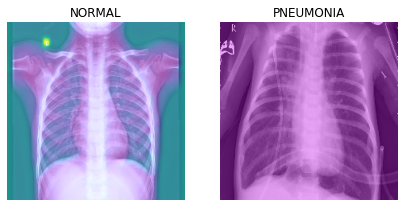

In [71]:
explainer = GradCAM()
tf.config.run_functions_eagerly(True)
plt.figure(figsize=(7, 5))
for i, img in enumerate(images):
    data = ([img], None)
    grid = explainer.explain(data, model, class_index=0, image_weight=0.8)
    plt.subplot(1, 2, i+1)
    plt.imshow(grid)
    plt.title(titles[i])
    plt.axis('off')
tf.config.run_functions_eagerly(False)

#### Integrated Gradients

https://arxiv.org/pdf/1703.01365.pdf

The **Integrated Gradients** method combines the Implementation Invariance of Gradients along with the Sensitivity techniques like LRP or DeepLift:
- **Sensitivity**: an attribution method satisfies *Sensitivity* if for every input and baseline that differ in one feature but have different predictions then the differing feature should be given a non-zero attribution.
- **Implementation Invariance**: an attribution method satisfies *Implementation variance* if the attributions are always identical for two functionally equivalent networks.

Suppose we have a functions $F: R^n -> [0,1]$ that represents a neural network. And let $x \in R^n$ be the input at hand and $x^{'} \in R^n$ be the baseline input, such as the black image. The method considers a straightline path from the baseline input $x^{'}$ to the input $x$, and computes the gradients at all points along the path. Integrated gradient are obtained by cumulating these gradients.

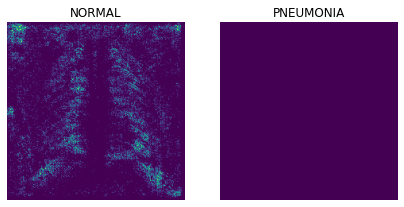

In [72]:
explainer = IntegratedGradients()
plt.figure(figsize=(7, 5))
for i, img in enumerate(images):
    data = ([img], None)
    grid = explainer.explain(data, model, class_index=0, n_steps=10)
    plt.subplot(1, 2, i+1)
    plt.imshow(grid)
    plt.title(titles[i])
    plt.axis('off')

As we can see from the results of both the methods above, the model has learned to recognize healty patients (NORMAL images).

#### During training

Now we are going to train the SCNNB model from zero and we are going to use the **GradCAMCallback** to visualize the activation of the network. The output of the callback can be visualized in tensorboard.

In [35]:
from tf_explain.callbacks import GradCAMCallback

In [36]:
test_gen_vis = test_datagen.flow_from_directory(config.TEST.dir_path,
                                                seed=0,
                                                batch_size=16,
                                                target_size=config.img_size[:2],
                                                class_mode='binary',
                                                shuffle=True)

Found 624 images belonging to 2 classes.


In [44]:
data = (test_gen_vis[0][0], None)

In [45]:
callbacks = [
    GradCAMCallback(data, class_index=0, output_dir="logs"),
]
# the target_layer is automatically chosen by GradCAM

In [46]:
model = get_SCNNB()
model = compile_model(model, 0.01)

In [47]:
tf.config.run_functions_eagerly(True)
model.fit(train_gen, epochs=2,
          validation_data=val_gen,
          class_weight=weights,
          callbacks=callbacks)
tf.config.run_functions_eagerly(False)

Epoch 1/2
147/147 [==============================] - 90s 615ms/step - loss: 1.0106 - binary_accuracy: 0.7387 - val_loss: 3.9437 - val_binary_accuracy: 0.7428
Epoch 2/2
147/147 [==============================] - 92s 624ms/step - loss: 1.0134 - binary_accuracy: 0.7429 - val_loss: 3.9437 - val_binary_accuracy: 0.7428


Here is the visualization obtained in Tensorboard:

<img src="./img/grad_cam.png" alt="Grad-CAM output" width="400"/>